# Vaccinazioni

Vaccinazioni in Italia.

> Max Pierini

***

Fonte dati: 

- [Covid-19 Opendata Vaccini](https://github.com/italia/covid19-opendata-vaccini)
- [DPC-PCM COVID-19](https://github.com/pcm-dpc/COVID-19)
- [ISTAT](http://dati.istat.it/)

***

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv',
    parse_dates=['data']
)

In [3]:
tot = cov.totale_casi.values[0]

In [4]:
pop = pd.read_csv('pop_16.csv')

In [5]:
smr = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/anagrafica-vaccini-summary-latest.csv',
    parse_dates=['ultimo_aggiornamento']
)

In [6]:
print('Dati ottenuti il', dt.datetime.now().strftime('%d %b %Y %H:%M:%S'))

Dati ottenuti il 29 Apr 2021 00:26:43


In [7]:
print('Aggiornamento ottenuto del', smr.ultimo_aggiornamento.max().strftime('%d %b %Y'))

Aggiornamento ottenuto del 28 Apr 2021


# Ultimi dati

In [8]:
smr_melt = pd.DataFrame(smr.sum()).T.melt()

In [9]:
smr_cat = smr_melt[smr_melt.variable.str.contains('categoria')].copy(deep='True')

In [10]:
smr_cat['variable'] = smr_cat.variable.str.replace('categoria_', '')

In [11]:
smr_cat['variable'] = smr_cat.variable.str.replace('_sociosanitari', '')

In [12]:
smr_cat['variable'] = smr_cat.variable.str.replace('personale_', '')

In [13]:
smr.columns = smr.columns.str.replace('sesso_maschile', 'maschi')
smr.columns = smr.columns.str.replace('sesso_femminile', 'femmine')

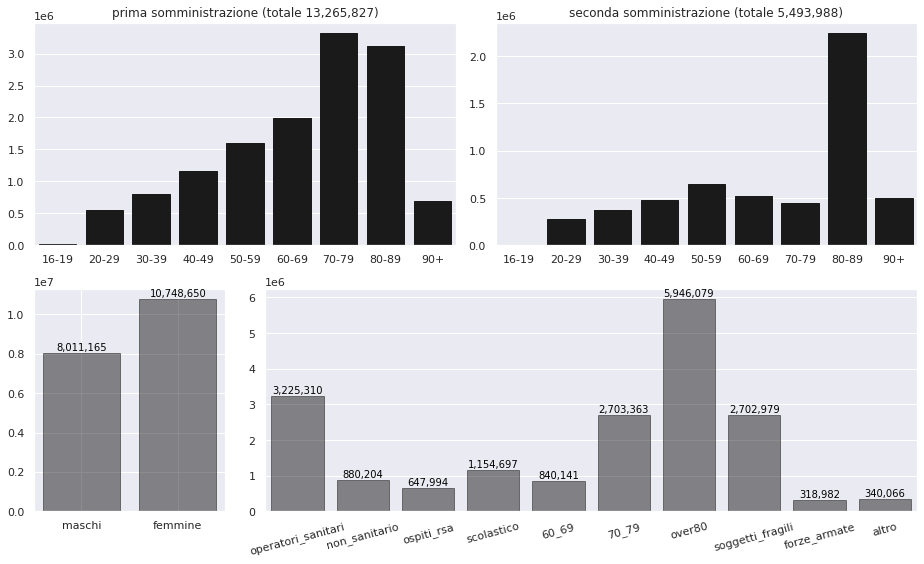

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(13, 8))
gs = gridspec.GridSpec(2, 4)
#fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ax0 = fig.add_subplot(gs[0, :2])
sns.barplot(
    data=smr, ax=ax0,
    x='fascia_anagrafica', y='prima_dose',
    color='k', ec='k',
)
ax0.set(
    title=f'prima somministrazione (totale {smr.prima_dose.sum():,})',
    xlabel=None, ylabel=None
)
ax1 = fig.add_subplot(gs[0, 2:])
sns.barplot(
    data=smr, ax=ax1,
    x='fascia_anagrafica', y='seconda_dose',
    color='k', ec='k',
)
ax1.set(
    title=f'seconda somministrazione (totale {smr.seconda_dose.sum():,})',
    xlabel=None, ylabel=None
)

ax2 = fig.add_subplot(gs[1, 0])
for y in ['maschi', 'femmine']:
    ax2.bar(y, smr.sum()[y], color='k', alpha=.5, ec='k')

gap2 = ax2.get_ylim()[1] / 75
for p in ax2.patches:
    ax2.text(p.get_x() + .4, 
            p.get_height() + gap2, 
           '{0:,.0f}'.format(p.get_height()),
            color='black', 
            ha='center',
            rotation='horizontal', 
            size='small')
    
ax3 = fig.add_subplot(gs[1, 1:])
g = sns.barplot(
    data=smr_cat,
    x='variable',
    y='value',
    color='k', ec='k',
    alpha=.5,
    ax=ax3
)

gap3 = ax3.get_ylim()[1] / 75
for p in ax3.patches:
    ax3.text(p.get_x() + .4, 
            p.get_height() + gap3, 
           '{0:,.0f}'.format(p.get_height()),
            color='black', 
            ha='center',
            rotation='horizontal', 
            size='small')

ax3.set(
    xlabel=None, ylabel=None
)
ax3.tick_params(axis='x', labelrotation=90/6)

#for y in ['prima_dose', 'seconda_dose']:
#    ax[1,1].bar(y, smr.sum()[y], color='k', ec='k')

_ = """
g = sns.barplot(
    data=reg,
    x='regione',
    y='somministrazioni',
    color='k', ec='k',
    ax=ax[1,1]
)

fig.suptitle(
    f"Vaccinazioni per COVID-19 in Italia, aggiornamento {sex.aggiornamento.max()}",
    fontsize=20,
)"""

plt.show()

# Fornitori

In [15]:
vax_ts = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/somministrazioni-vaccini-latest.csv',
    parse_dates=['data_somministrazione']
)

In [16]:
vax_ts.replace('Vaxzevria (AstraZeneca)', 'AstraZeneca', inplace=True)

In [17]:
vax_ts.replace('Pfizer/BioNTech', 'Pfizer', inplace=True)

In [18]:
it_ts = vax_ts.groupby('data_somministrazione').sum()

In [19]:
fornitori = vax_ts.groupby('fornitore')[['prima_dose', 'seconda_dose']].sum()

In [20]:
fornitori_melt = fornitori.reset_index().melt(id_vars='fornitore')

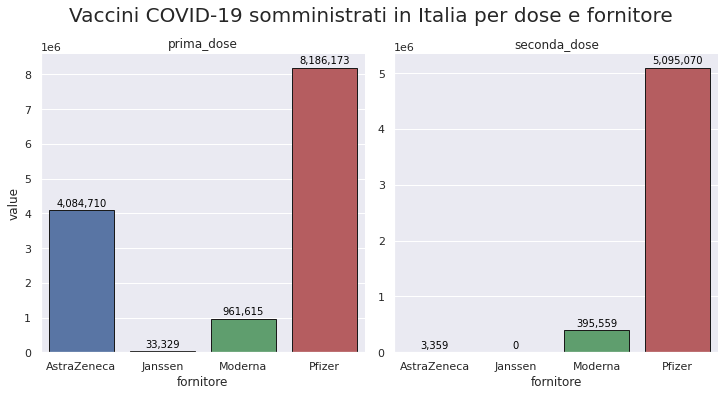

In [21]:
g = sns.catplot(
    kind='bar',
    data=fornitori_melt,
    x='fornitore', y='value',
    col='variable',
    ec='k',
    sharey=False
)

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    gap = ax.get_ylim()[1] / 75
    for p in ax.patches:
        ax.text(p.get_x() + .4, 
                p.get_height() + gap, 
               '{0:,.0f}'.format(p.get_height()),
                color='black', 
                ha='center',
                rotation='horizontal', 
                size='small')

g.fig.suptitle(
    'Vaccini COVID-19 somministrati in Italia per dose e fornitore',
    y=1.05, fontsize=20,
)
plt.show()

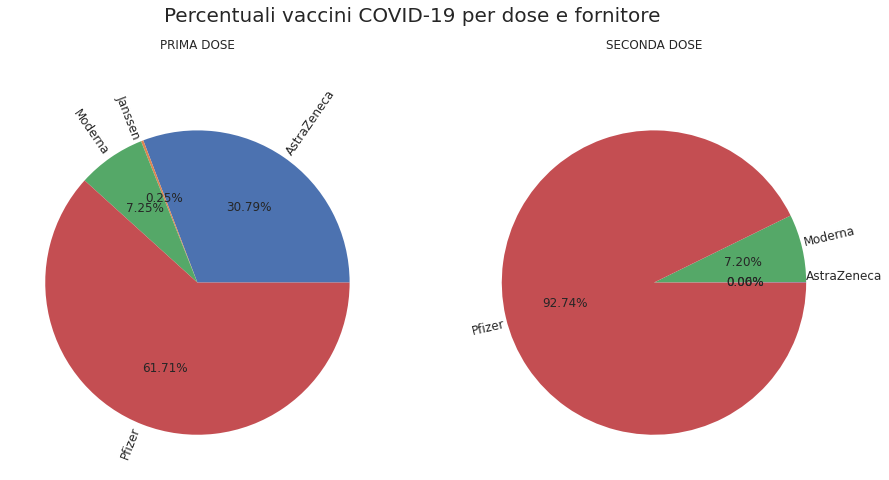

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(
    'Percentuali vaccini COVID-19 per dose e fornitore',
    fontsize=20, y=1.05
)
fornitori_prima_dose = fornitori.prima_dose
fornitori_prima_dose.name = ''
fornitori_prima_dose.plot.pie(
    autopct='%1.2f%%',
    startangle=0,
    xlabel=None, ylabel=None,
    legend=None,
    textprops=dict(fontsize=12),
    rotatelabels=True,
    labeldistance=1,
    wedgeprops=dict(ec='none'),
    ax=ax[0]
)
ax[0].set_title('PRIMA DOSE', y=1.1)
fornitori_seconda_dose = fornitori.seconda_dose
fornitori_seconda_dose.name = ''
fornitori_seconda_dose.plot.pie(
    autopct='%1.2f%%',
    startangle=0,
    xlabel=None, ylabel=None,
    legend=None,
    textprops=dict(fontsize=12),
    rotatelabels=True,
    labeldistance=1,
    wedgeprops=dict(ec='none'),
    ax=ax[1]
)
ax[1].set_title('SECONDA DOSE', y=1.1)
plt.show()

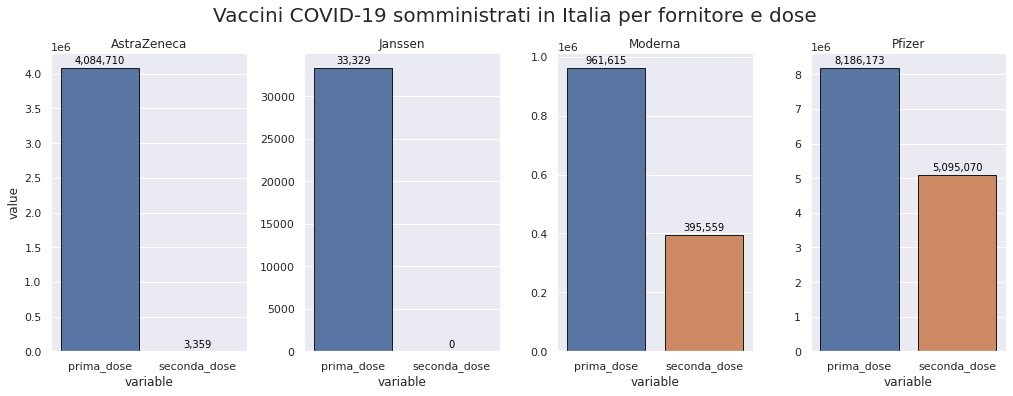

In [23]:
g = sns.catplot(
    kind='bar',
    data=fornitori_melt,
    x='variable', y='value',
    col='fornitore',
    ec='k',
    sharey=False,
    aspect=.7
)

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    gap = ax.get_ylim()[1] / 75
    for p in ax.patches:
        ax.text(p.get_x() + .4, 
                p.get_height() + gap, 
               '{0:,.0f}'.format(p.get_height()),
                color='black', 
                ha='center',
                rotation='horizontal', 
                size='small')

g.fig.suptitle(
    'Vaccini COVID-19 somministrati in Italia per fornitore e dose',
    y=1.05, fontsize=20,
)
plt.show()

# Totali

In [24]:
popolazione_italia = pop[pop.regione=='Italia'].popolazione.values[0]

In [25]:
pop_it = popolazione_italia - tot

In [26]:
Markdown(fr"""
Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{{pop}}_{{it}} = {f"{popolazione_italia:,}".replace(",", "'")} \textrm{{ persone}}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{{S}}_{{it}} = \mathbf{{pop}}_{{it}} - \mathbf{{COVID}}_{{it}} =
{f"{popolazione_italia:,}".replace(",", "'")} - {f"{tot:,}".replace(",", "'")} = 
{f"{pop_it:,}".replace(",", "'")} \textrm{{ persone}}
$$
""")


Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{pop}_{it} = 51'341'724 \textrm{ persone}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{S}_{it} = \mathbf{pop}_{it} - \mathbf{COVID}_{it} =
51'341'724 - 3'994'894 = 
47'346'830 \textrm{ persone}
$$


In [27]:
E = .95
R0 = 3
HIT = 1 - 1 / R0
V = HIT / E
V_it = V * pop_it
HIT_it = HIT * pop_it
VAX = smr.sum().seconda_dose
VAX_pct = VAX / pop_it

VAX1 = smr.sum().prima_dose
VAX1_pct = VAX1 / pop_it

Markdown(fr"""
Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0={R0}$

$$
\mathbf{{HIT}} = 1 - \frac{{1}}{{R_0}} = {HIT * 100:.0f}\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{{HIT}}_{{it}} = \mathbf{{HIT}} \cdot \mathbf{{S}}_{{it}} = 
{f"{HIT_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

Data l'efficacia vaccinale **E** del {E:.0%}
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{{V}} = \frac{{ \mathbf{{HIT}} }}{{ \mathbf{{E}} }} = 
\frac{{{HIT:.2f}}}{{{E:.2f}}} = {V*100:.0f}\%
$$

pertanto, la minima copertura vaccinale per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{{V}}_{{it}} = \mathbf{{V}} \cdot \mathbf{{S}}_{{it}} = 
{f"{V_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

***

Attuale numero di vaccini completi somministrati (prima dose)

$$
\mathbf{{VAX}}_1 = {f"{VAX1:,.0f}".replace(",", "'")} \textrm{{ vaccini}}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{{VAX}}_1\% = \frac{{ \mathbf{{VAX}}_1 }}{{ \mathbf{{S}}_{{it}} }} =
{VAX1_pct * 100:.2f}\%
$$

***

Attuale numero di vaccini completi somministrati (seconda dose)

$$
\mathbf{{VAX}}_2 = {f"{VAX:,.0f}".replace(",", "'")} \textrm{{ vaccini}}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{{VAX}}_2\% = \frac{{ \mathbf{{VAX}}_2 }}{{ \mathbf{{S}}_{{it}} }} =
{VAX_pct * 100:.2f}\%
$$
""")


Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0=3$

$$
\mathbf{HIT} = 1 - \frac{1}{R_0} = 67\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{HIT}_{it} = \mathbf{HIT} \cdot \mathbf{S}_{it} = 
31'564'553 \textrm{ abitanti}
$$

Data l'efficacia vaccinale **E** del 95%
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{V} = \frac{ \mathbf{HIT} }{ \mathbf{E} } = 
\frac{0.67}{0.95} = 70\%
$$

pertanto, la minima copertura vaccinale per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{V}_{it} = \mathbf{V} \cdot \mathbf{S}_{it} = 
33'225'846 \textrm{ abitanti}
$$

***

Attuale numero di vaccini completi somministrati (prima dose)

$$
\mathbf{VAX}_1 = 13'265'827 \textrm{ vaccini}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{VAX}_1\% = \frac{ \mathbf{VAX}_1 }{ \mathbf{S}_{it} } =
28.02\%
$$

***

Attuale numero di vaccini completi somministrati (seconda dose)

$$
\mathbf{VAX}_2 = 5'493'988 \textrm{ vaccini}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{VAX}_2\% = \frac{ \mathbf{VAX}_2 }{ \mathbf{S}_{it} } =
11.60\%
$$


In [28]:
vax_Y = it_ts.cumsum().replace(0, np.nan)[['seconda_dose']].dropna()[-7:].seconda_dose.values.ravel()
vax_X = np.arange(vax_Y.size)
vax_X = sm.add_constant(vax_X)
mod = sm.OLS(vax_Y, vax_X)
res = mod.fit()
VAX_n = res.params[1]
vax_i = res.params[0]

In [29]:
VAX_pred = vax_i + np.arange(14) * VAX_n

In [30]:
min_idx = vax_Y.size
pred_dates = pd.date_range(
    it_ts.index[-min_idx].date(),
    it_ts.index[-min_idx] + pd.Timedelta(days=13),
)

In [31]:
HIT_rem = V_it - VAX

In [32]:
REM_d = HIT_rem / VAX_n

> **NOTA BENE**: la seguente stima sarà attendibile nel momento in cui la somministrazione delle seconde dosi sarà a pieno regime.

In [33]:
Markdown(fr"""
Vaccini somministrati (seconda dose) mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{{VAX}}_{{n}} = \frac{{\mathbf{{VAX}}_2}}{{\mathrm{{giorni}}}} \simeq 
{f"{VAX_n:,.0f}".replace(",", "'")} 
\textrm{{ vaccini al giorno }}
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{{VAX}}_{{rem}} = \mathbf{{V}}_{{it}} - \mathbf{{VAX}} = 
{f"{HIT_rem:,.0f}".replace(",", "'")}
\textrm{{ abitanti}}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{{T}}_{{rem}} = \frac{{\mathbf{{VAX}}_{{rem}}}}{{\mathbf{{VAX}}_{{n}}}} =
{f"{REM_d:,.0f}".replace(",", "'")} \textrm{{ giorni}}
= {REM_d/365*12:,.0f} \textrm{{ mesi}}
= {REM_d/365:,.1f} \textrm{{ anni}}
$$
""")


Vaccini somministrati (seconda dose) mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{VAX}_{n} = \frac{\mathbf{VAX}_2}{\mathrm{giorni}} \simeq 
89'300 
\textrm{ vaccini al giorno }
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{VAX}_{rem} = \mathbf{V}_{it} - \mathbf{VAX} = 
27'731'858
\textrm{ abitanti}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{T}_{rem} = \frac{\mathbf{VAX}_{rem}}{\mathbf{VAX}_{n}} =
311 \textrm{ giorni}
= 10 \textrm{ mesi}
= 0.9 \textrm{ anni}
$$


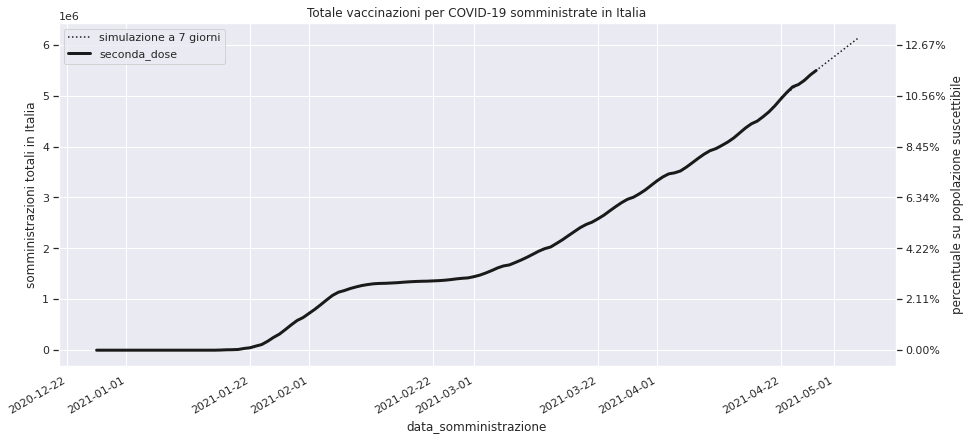

In [34]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
ax.plot(pred_dates, VAX_pred, ls=':', color='k', label='simulazione a 7 giorni')
it_ts.cumsum().plot(
    y='seconda_dose',
    title='Totale vaccinazioni per COVID-19 somministrate in Italia',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)

ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.2%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend()

plt.show()

In [35]:
HIT_pred_dates = pd.date_range(
    it_ts.index[-min_idx],
    it_ts.index[-min_idx] + pd.Timedelta(days=REM_d+6),
)

In [36]:
HIT_pred = vax_i + VAX_n * np.arange(HIT_pred_dates.size)

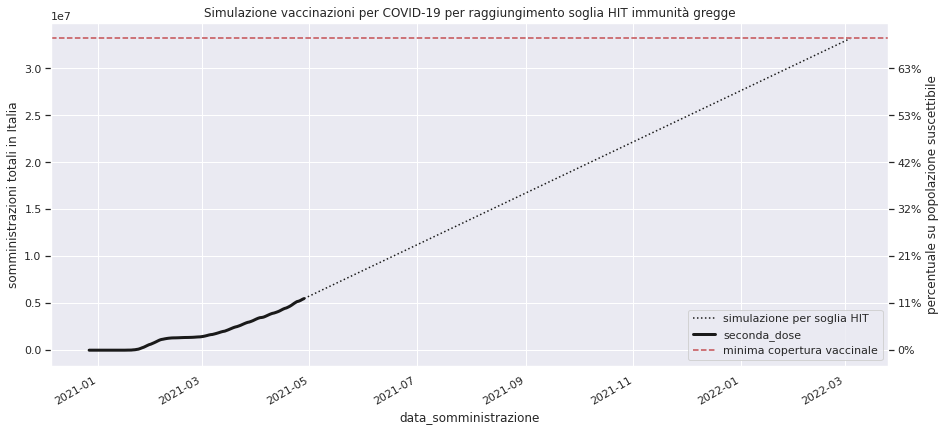

In [37]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
ax.plot(HIT_pred_dates, HIT_pred, ls=':', color='k', label='simulazione per soglia HIT')
it_ts.cumsum().plot(
    y='seconda_dose',
    title='Simulazione vaccinazioni per COVID-19 per raggiungimento soglia HIT immunità gregge',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)
ax.axhline(V_it, color='r', ls='--', label='minima copertura vaccinale')
ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.0%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend(loc='lower right')

plt.show()

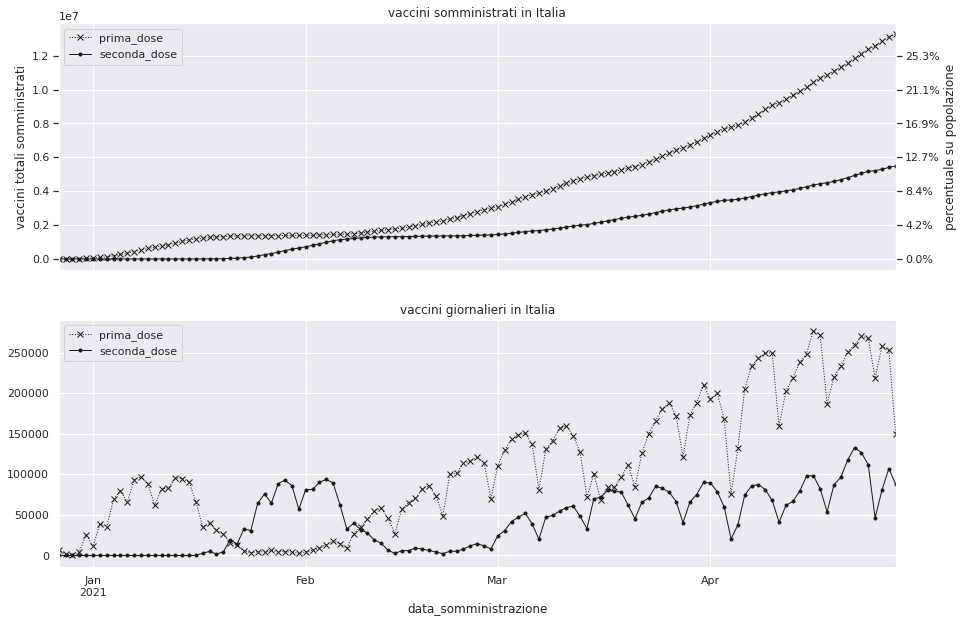

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

it_ts.cumsum().plot(
    y='prima_dose', ax=ax[0], color='k', marker='x', lw=1, ls=':',
    title='vaccini somministrati in Italia',
    legend='prima dose',
)
it_ts.cumsum().plot(
    y='seconda_dose', ax=ax[0], color='k', marker='.', lw=1,
    #title='vaccini somministrati SECONDA DOSE',
    legend='seconda dose',
)
ax[0].set(
    ylabel='vaccini totali somministrati'
)
ax1 = ax[0].twinx()
ax1.set_ylim(ax[0].get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.1%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione'
)
ax1.set_ylim(ax[0].get_ylim())
ax1.grid(alpha=0)


it_ts.plot(
    y='prima_dose', ax=ax[1], color='k', marker='x', lw=1, ls=':',
    title='vaccini giornalieri in Italia',
    legend='prima dose',
)
it_ts.plot(
    y='seconda_dose', ax=ax[1], color='k', marker='.', lw=1,
    legend='seconda dose',
)

plt.show()

# Regioni

In [39]:
pop.regione = pop.regione.str.replace("Valle d'Aosta / Vallée d'Aoste", "Valle d'Aosta")

In [40]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Bolzano / Bozen", "P.A. Bolzano")

In [41]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Trento", "P.A. Trento")

In [42]:
pop.regione = pop.regione.str.replace("Friuli-Venezia Giulia", "Friuli-Venezia-Giulia")

In [43]:
iss_to_name = {}
nomi = pop.regione[1:].sort_values().values
for i, codice in enumerate(vax_ts.area.sort_values().unique()):
    iss_to_name.update({codice: nomi[i]})

In [44]:
vax_ts['regione'] = vax_ts.area.map(iss_to_name)

In [45]:
vax_cum = None
for regione in vax_ts.regione.unique():
    _df = vax_ts[vax_ts.regione==regione]
    _df_sum = _df.groupby('data_somministrazione').sum().cumsum()
    _df_sum['regione'] = regione
    if vax_cum is None:
        vax_cum = _df_sum
    else:
        vax_cum = vax_cum.append(_df_sum)

In [46]:
reg = vax_cum.reset_index().merge(
    pop,
    on='regione'
)

In [47]:
reg.sort_values(by='regione', inplace=True)

In [48]:
reg['percentuale prima_dose'] = reg.prima_dose / reg.popolazione
reg['percentuale seconda_dose'] = reg.seconda_dose / reg.popolazione

In [49]:
cols1 = ['data_somministrazione', 'regione', 'percentuale prima_dose', 'prima_dose']
reg_last1 = None
for regione in reg.regione.unique():
    _reg_df = reg[reg.regione==regione][cols1].sort_values(by='data_somministrazione')
    _max_dt = _reg_df.replace(0, np.nan).dropna().data_somministrazione.max()
    _last = _reg_df[_reg_df.data_somministrazione==_max_dt]
    if reg_last1 is None:
        reg_last1 = _last
    else:
        reg_last1 = reg_last1.append(_last)

In [50]:
cols2 = ['data_somministrazione', 'regione', 'percentuale seconda_dose', 'seconda_dose']
reg_last2 = None
for regione in reg.regione.unique():
    _reg_df = reg[reg.regione==regione][cols2].sort_values(by='data_somministrazione')
    _max_dt = _reg_df.replace(0, np.nan).dropna().data_somministrazione.max()
    _last = _reg_df[_reg_df.data_somministrazione==_max_dt]
    if reg_last2 is None:
        reg_last2 = _last
    else:
        reg_last2 = reg_last2.append(_last)

In [51]:
reg_last1.set_index('regione')[['prima_dose', 'percentuale prima_dose']].style.format({
    'prima_dose': '{:,}',
    'percentuale prima_dose': '{:.1%}'
})

,prima_dose,percentuale prima_dose
regione,,
Abruzzo,"298,034",26.5%
Basilicata,"121,064",25.1%
Calabria,"356,131",21.9%
Campania,"1,167,758",24.2%
Emilia-Romagna,"1,053,035",27.4%
Friuli-Venezia-Giulia,"274,693",26.1%
Lazio,"1,275,281",25.8%
Liguria,"400,466",29.8%
Lombardia,"2,219,569",25.8%


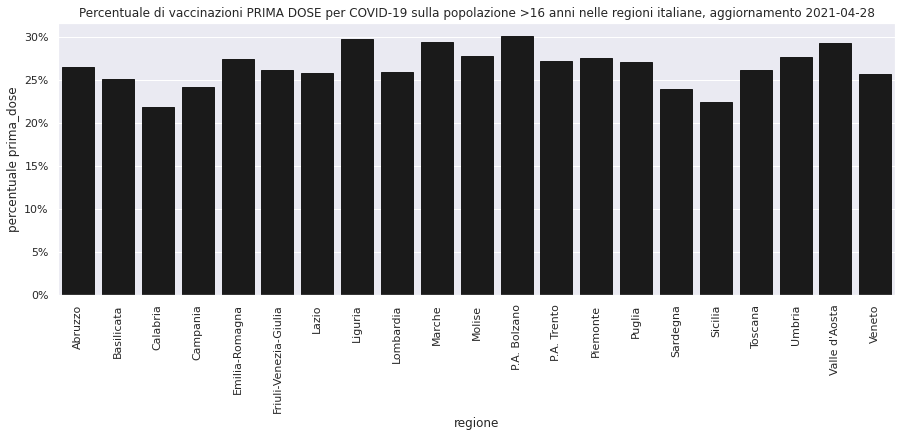

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=reg_last1,
    x='regione',
    y='percentuale prima_dose',
    color='k', ec='k',
    ax=ax
)
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
ax.set(
    title=f"Percentuale di vaccinazioni PRIMA DOSE per COVID-19 sulla popolazione >16 anni nelle regioni italiane, aggiornamento {reg_last1.data_somministrazione.max().date()}",
)
plt.show()

In [53]:
reg_last2.set_index('regione')[['seconda_dose', 'percentuale seconda_dose']].style.format({
    'seconda_dose': '{:,}',
    'percentuale seconda_dose': '{:.1%}'
})

,seconda_dose,percentuale seconda_dose
regione,,
Abruzzo,"117,006",10.4%
Basilicata,"52,469",10.9%
Calabria,"152,873",9.4%
Campania,"439,153",9.1%
Emilia-Romagna,"493,715",12.8%
Friuli-Venezia-Giulia,"128,610",12.2%
Lazio,"556,259",11.2%
Liguria,"171,415",12.7%
Lombardia,"893,589",10.4%


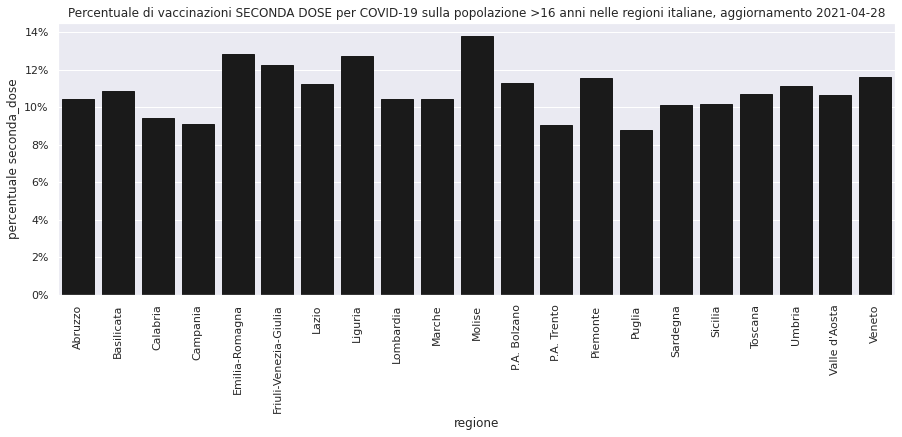

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=reg_last2,
    x='regione',
    y='percentuale seconda_dose',
    color='k', ec='k',
    ax=ax
)
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
ax.set(
    title=f"Percentuale di vaccinazioni SECONDA DOSE per COVID-19 sulla popolazione >16 anni nelle regioni italiane, aggiornamento {reg_last2.data_somministrazione.max().date()}",
)
plt.show()

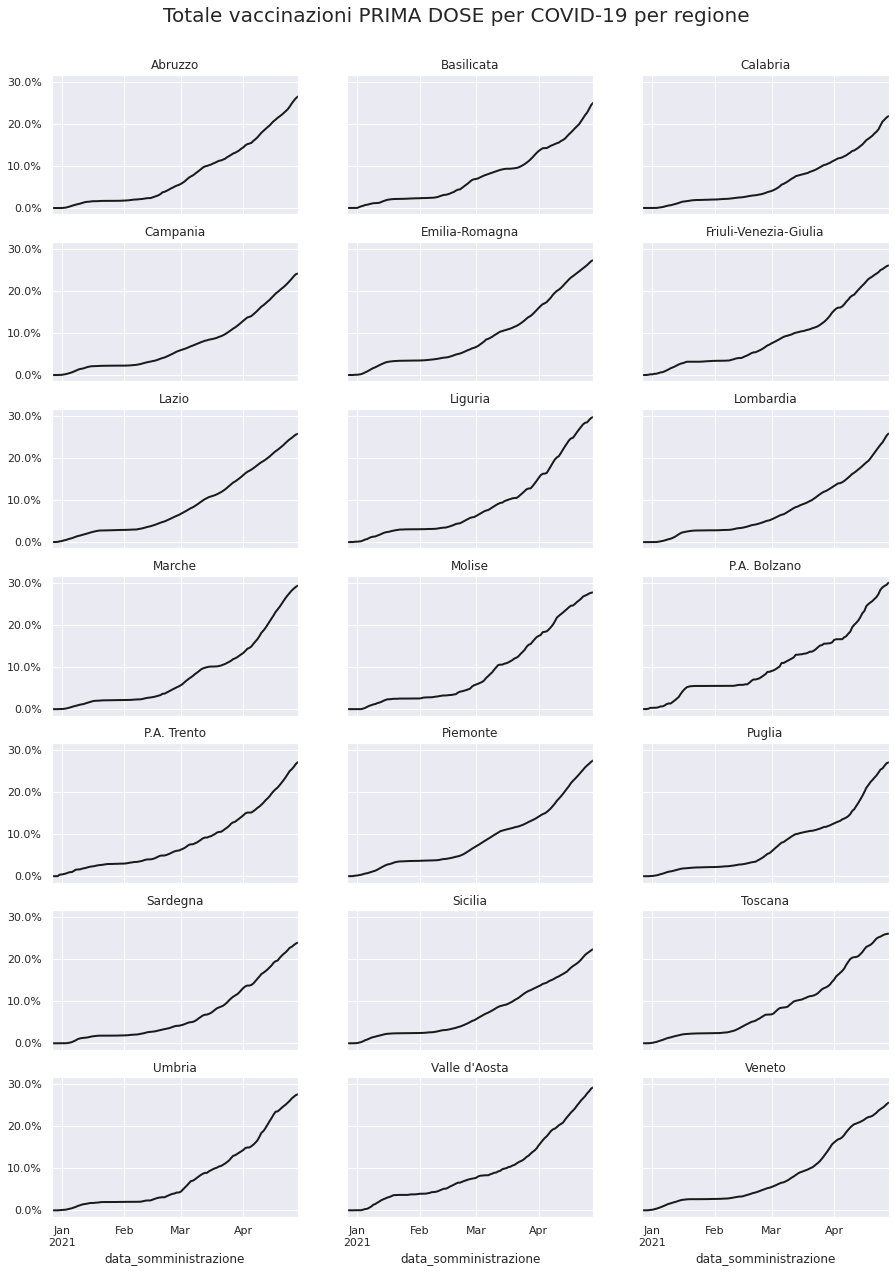

In [55]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione].copy(deep=True)
    _ts.set_index('data_somministrazione', inplace=True)
    _ts = _ts.resample('D').mean()
    _ts.fillna(method='ffill', inplace=True)
    _ts.reset_index(inplace=True)
    _ts.plot(
        x='data_somministrazione', y='percentuale prima_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
for axis in ax.flat:
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
#for i, regione in enumerate(reg.regione.unique()):
#    _ts = reg[reg.regione==regione]
#    ax1 = ax.flat[i].twinx()
#    ax1.set_ylim(ax.flat[i].get_ylim())
#    ax1.set(
#        yticks=ax1.get_yticks(),
#        yticklabels=[f"{p:.0%}" for p in ax1.get_yticks() / _ts.popolazione.values[0]],
#        #ylabel='percentuale su popolazione suscettibile'
#    )
#    ax1.set_ylim(ax.flat[i].get_ylim())
#    ax1.grid(alpha=0)

fig.suptitle("Totale vaccinazioni PRIMA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

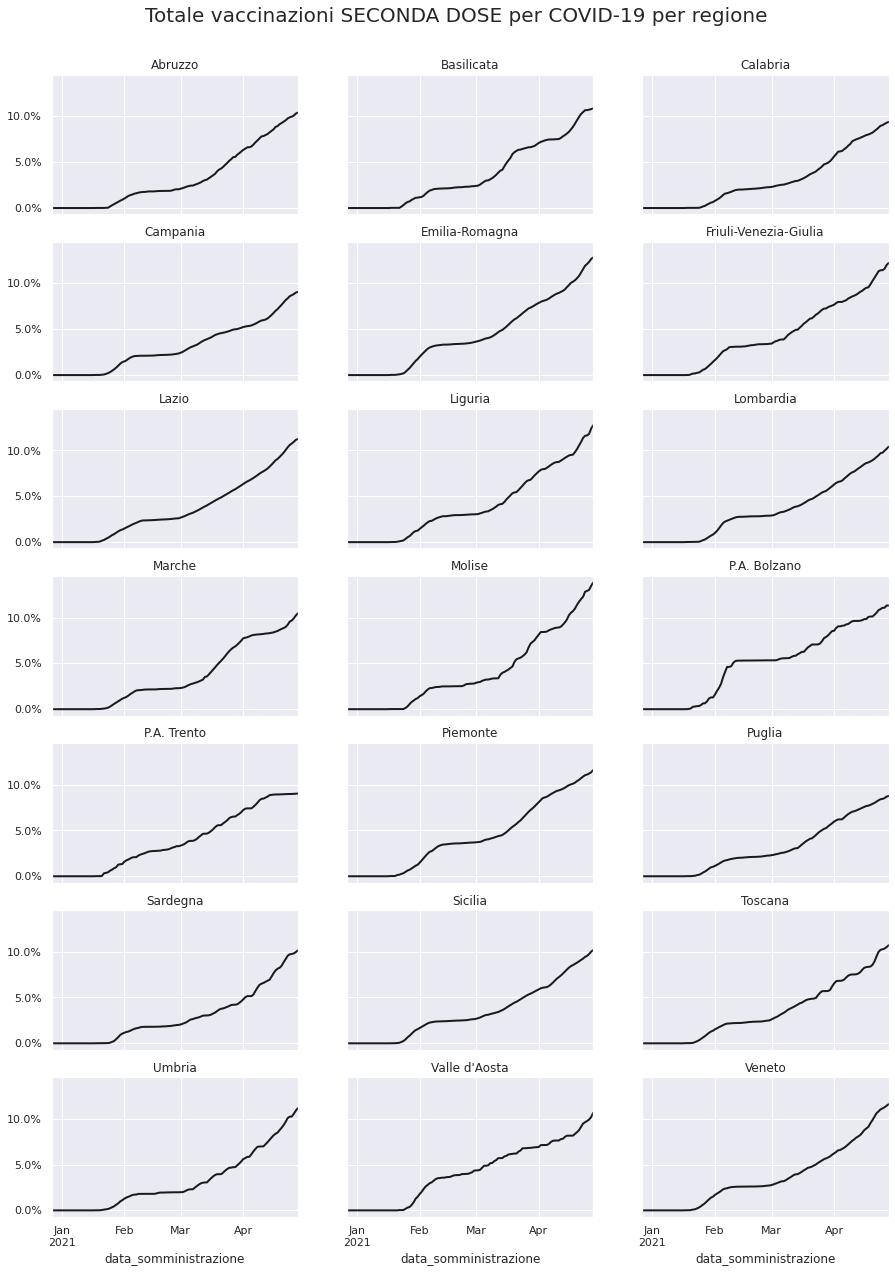

In [56]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione].copy(deep=True)
    _ts.set_index('data_somministrazione', inplace=True)
    _ts = _ts.resample('D').mean()
    _ts.fillna(method='ffill', inplace=True)
    _ts.reset_index(inplace=True)
    _ts.plot(
        x='data_somministrazione', y='percentuale seconda_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
for axis in ax.flat:
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
#for i, regione in enumerate(reg.regione.unique()):
#    _ts = reg[reg.regione==regione]
#    ax1 = ax.flat[i].twinx()
#    ax1.set_ylim(ax.flat[i].get_ylim())
#    ax1.set(
#        yticks=ax1.get_yticks(),
#        yticklabels=[f"{p:.0%}" for p in ax1.get_yticks() / _ts.popolazione.values[0]],
#        #ylabel='percentuale su popolazione suscettibile'
#    )
#    ax1.set_ylim(ax.flat[i].get_ylim())
#    ax1.grid(alpha=0)

fig.suptitle("Totale vaccinazioni SECONDA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()